# Comparison between naturalistic reaches and cued hand clenches

Subjects 01 - 03 also participated in controlled experiments where they were visually cued to clench their hand (contralateral hand to placement of ECoG electrode implantation hemisphere). The behavior and neural responses during these cued movements can be compared to the spontaneous, naturalistic reaches in the contralateral wrist that we were interested in studying. This notebook will generate all plots from Fig. 5 in the paper.

In [1]:
%matplotlib inline
import glob, natsort, mne, sys, pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.time_frequency import read_tfrs
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import pingouin as pg

import config
from tfr_utils import tfr_boot_sig_mask,compute_tfr,plot_ecog_electrodes_mni_in_order,tfr_subtract_baseline,\
                      compute_wrist_radial_distance,create_spectral_features,compute_voltage_variable,\
                      plot_spectral_power_variability_stats
from feat_plot_utils import plot_behavior_traces

/home/stepeter/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Set parameters

In [2]:

tfr_lp_reaches = '/data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/'
epochs_lp_clenches = '/data1/users/stepeter/mvmt_init/data_release/hand_clenches/'
n_subjs = 3
n_conds = 2 #2 conditions: 1) naturalistic reaches, 2) cued hand clenches
freq_bands = [[8,32],[76,100]]
t_ave_secs = [0,0.5] #time averaged over for spectral features (in seconds)

#Plotting variables
fband_label = ['LFB','HFB']
cond_labels = ['Experimental','Naturalistic']
my_pal_spectral_var = {cond_labels[0]: "darkgray", cond_labels[1]: "w"}

#Load variables from config file
baseline_reaches = config.constants_plot_tfr['baseline_vals']
baseline_clenches = config.constants_hand_clench_tfr['baseline_vals']
pwr_decim_clenches = config.constants_hand_clench_tfr['pwr_decim_clenches']
Fs_cyber = config.constants_hand_clench_tfr['fs_ecog'] #Hz
vscale_val = config.constants_plot_chan_tfr_compare['vscale_val'] #plotting color scale
cmap_label = config.constants_plot_chan_tfr_compare['cmap_label']


### Load in naturalistic reach data and compute behavioral and neural features for plotting

In [5]:
ave_pow_patients = np.empty([n_conds,n_subjs,len(freq_bands)],dtype=object)
SD_vals = ave_pow_patients.copy()
df_contra_wrist_all_reaches = []

#Load in reach data first
elec_locs,bad_chans = [],[]
for i in range(n_subjs):
    fnames_all = natsort.natsorted(glob.glob(tfr_lp_reaches+'subj_'+str(i+1).zfill(2)+'*.h5'))

    #Load spectral power (TFR) files
    for s,fname in enumerate(fnames_all):
        wrist_contra = fname.split('_')[-3]
        power_temp = mne.time_frequency.read_tfrs(fname)[0]
        
        if s==0:
            elec_locs_temp = np.zeros([len(power_temp.info['chs']),3])
            for k in range(len(power_temp.info['chs'])):
                elec_locs_temp[k,:] = power_temp.info['chs'][k]['loc'][:3]
            elec_locs.append(elec_locs_temp)
            
            bad_chans_tmp = []
            for k,bad_ch in enumerate(power_temp.info['bads']):
                bad_chans_tmp.append(np.nonzero(bad_ch==np.asarray(power_temp.info['ch_names']))[0][0])
            bad_chans.append(np.asarray(bad_chans_tmp))
        
        #Drop any bad epochs
        keep_inds = np.nonzero(~np.isnan(np.mean(np.reshape(power_temp.data,
                               (power_temp.data.shape[0],-1)),axis=1)))[0]
        power_temp.data = power_temp.data[keep_inds,...]
            
        #Extract position data from contralateral wrist
        contra_metadata = power_temp.metadata.loc[:,[wrist_contra+'_wrist_x',wrist_contra+'_wrist_y']]
        
        #Combine values across days
        if s==0:
            power = power_temp.copy()
            contra_metadata_sbj = contra_metadata.copy()
        else:
            power.data = np.concatenate((power.data,power_temp.data),axis=0)    
            contra_metadata_sbj = pd.concat((contra_metadata_sbj,contra_metadata),ignore_index=True)
        del power_temp
    
    #Compute radial distance
    df_contra_wrist = compute_wrist_radial_distance(contra_metadata_sbj,wrist_contra)
    
    #Make power only 2 frequency bands
    baseidx = np.nonzero(np.logical_and(power.times>=baseline_reaches[0],power.times<=baseline_reaches[1]))[0]
    
    #Compute spectral features
    if i==0:
        df_mad = None
    
    power_ave,tind0,df_mad = create_spectral_features(power,freq_bands,baseidx,t_ave_secs,
                                                      condition=cond_labels[1],df_mad=df_mad,
                                                      fband_label=fband_label)
    
    #Save to variables for all subjects
    df_contra_wrist_all_reaches.append(df_contra_wrist)
    for k in range(power_ave.data.shape[1]):
        vals=list()
        for j in range(power_ave.data.shape[0]):
            vals.append(power_ave.data[j,k,tind0])
        ave_pow_patients[0,i,k] = vals.copy()

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_3_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_4_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_5_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns


100%|██████████| 94/94 [03:19<00:00,  2.12s/it]

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_3_l_allEpochs_tfr.h5 ...


Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_4_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_5_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_6_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns


100%|██████████| 86/86 [00:59<00:00,  1.45it/s]

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_03_day_3_r_allEpochs_tfr.h5 ...


Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_03_day_4_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_03_day_5_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_03_day_6_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns


100%|██████████| 80/80 [02:31<00:00,  1.88s/it]


### Load in hand clench data, calculate power, and compute behavioral and neural features for plotting

In [8]:
#Load in hand clench data and compute spectral power
df_voltage_all_clenches = []
for i in range(n_subjs):
    fnames_all = natsort.natsorted(glob.glob(epochs_lp_clenches+'subj_'+str(i+1).zfill(2)+'*.fif'))

    #Load spectral power (TFR) files
    for s,fname in enumerate(fnames_all):
        wrist_contra = fname.split('_')[-3]
        ep_dat = mne.read_epochs(fname)
        pad_val = config.constants_compute_tfr['pad_val']
        epoch_times = [ep_dat.times.min()+pad_val, ep_dat.times.max()-pad_val]
        
        power_temp = compute_tfr(ep_dat,epoch_times,
                                 freqs = config.constants_compute_tfr['freqs'],
                                 crop_val=pad_val,
                                 decim=pwr_decim_clenches)
        
        #Drop any bad epochs
        keep_inds = np.nonzero(~np.isnan(np.mean(np.reshape(power_temp.data,
                               (power_temp.data.shape[0],-1)),axis=1)))[0]
        power_temp.data = power_temp.data[keep_inds,...]
            
        #Extract position data from contralateral wrist
        voltage_metadata = power_temp.metadata.loc[:,['glove_voltage']]
        
        #Combine values across days
        if s==0:
            power = power_temp.copy()
            voltage_metadata_sbj = voltage_metadata.copy()
        else:
            power.data = np.concatenate((power.data,power_temp.data),axis=0)    
            voltage_metadata_sbj = pd.concat((voltage_metadata_sbj,voltage_metadata),ignore_index=True)
        del power_temp
    
    #Convert voltage values for plotting
    df_voltage = compute_voltage_variable(voltage_metadata_sbj)
    
    baseidx = np.nonzero(np.logical_and(power.times>=baseline_clenches[0],\
                                        power.times<=baseline_clenches[1]))[0]
    
    power_ave,tind0,df_mad = create_spectral_features(power,freq_bands,baseidx,t_ave_secs,
                                                      condition=cond_labels[0],df_mad=df_mad,
                                                      fband_label=fband_label)
    
    #Save to variables for all subjects
    df_voltage_all_clenches.append(df_voltage)
    for k in range(power_ave.data.shape[1]):
        vals=list()
        for j in range(power_ave.data.shape[0]):
            vals.append(power_ave.data[j,k,tind0])
        ave_pow_patients[1,i,k] = vals.copy()

Reading /data1/users/stepeter/mvmt_init/data_release/hand_clenches/subj_01_epo.fif ...
    Found the data of interest:
        t =   -2500.20 ...    2999.91 ms
        0 CTF compensation matrices available
10 matching events found
No baseline correction applied
Adding metadata with 1 columns
0 projection items activated
Computing power...
Adding metadata with 1 columns


  2%|▏         | 2/94 [00:00<00:04, 19.92it/s]

Power computation complete!


100%|██████████| 94/94 [00:04<00:00, 19.70it/s]

Reading /data1/users/stepeter/mvmt_init/data_release/hand_clenches/subj_02_epo.fif ...
    Found the data of interest:
        t =   -2500.20 ...    2999.91 ms
        0 CTF compensation matrices available


10 matching events found
No baseline correction applied
Adding metadata with 1 columns
0 projection items activated
Computing power...
Adding metadata with 1 columns


  2%|▏         | 2/86 [00:00<00:04, 19.67it/s]

Power computation complete!


100%|██████████| 86/86 [00:04<00:00, 19.67it/s]

Reading /data1/users/stepeter/mvmt_init/data_release/hand_clenches/subj_03_epo.fif ...
    Found the data of interest:
        t =   -2500.20 ...    2999.91 ms
        0 CTF compensation matrices available


10 matching events found
No baseline correction applied
Adding metadata with 1 columns
0 projection items activated
Computing power...
Adding metadata with 1 columns


  2%|▎         | 2/80 [00:00<00:03, 19.95it/s]

Power computation complete!


100%|██████████| 80/80 [00:04<00:00, 19.73it/s]


### Compare behavioral traces

Voltage of data glove for cued hand clenches. Wrist displacements for naturalistic reaches.

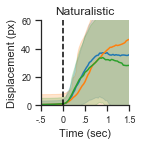

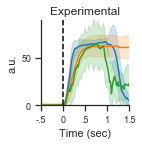

In [9]:
plot_behavior_traces(df_contra_wrist_all_reaches,condition_label=cond_labels[1],ylim_max=60,
                     ylabel='Displacement (px)')
plot_behavior_traces(df_voltage_all_clenches,condition_label=cond_labels[0],ylim_max=90,
                     ylabel='a.u.')

### Compare channel-level spectral power

/home/stepeter/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/stepeter/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stepeter/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


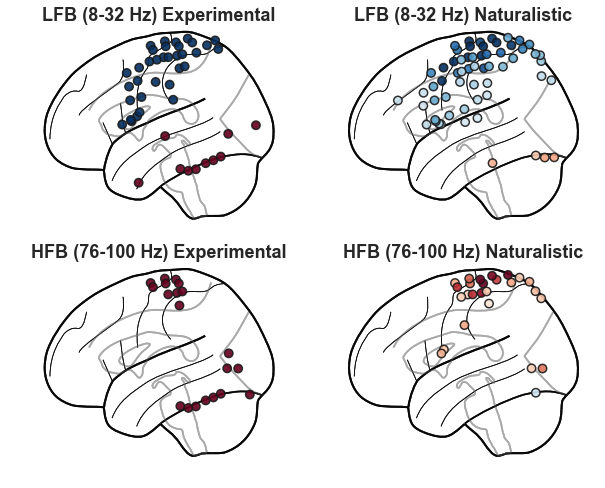

In [10]:
colors_all = np.empty([n_conds,n_subjs,len(freq_bands)],dtype=object)
vals_all = colors_all.copy()

#Compute colors for plotting
cmap = get_cmap(cmap_label)
norm = Normalize(vmin=-vscale_val, vmax=vscale_val)
for k in range(n_conds):
    for s in range(n_subjs):
        for i in range(len(freq_bands)):
            colors,vals_tmp=[],[]
            for j in range(len(ave_pow_patients[k,s,i])):
                vals_tmp.append(ave_pow_patients[k,s,i][j])
                if ave_pow_patients[k,s,i][j]==0:
                    colors.append([1,1,1])
                else:
                    colors.append(cmap(norm(ave_pow_patients[k,s,i][j]))[0:3])
            colors_all[k,s,i] = colors.copy()
            vals_all[k,s,i] = vals_tmp.copy()
            
#Plot results
n_rows,n_cols = 2,2
fTitles = ['LFB ({}-{} Hz)'.format(freq_bands[0][0],freq_bands[0][1]),
           'HFB ({}-{} Hz)'.format(freq_bands[1][0],freq_bands[1][1])]
node_edge_colors = ['green','maroon','lime','teal','brown','black','olive','gray']

f, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True,figsize=(10,8))
for i in range(n_conds):
    ii = n_conds - 1 - i #flip condition order for plotting
    for j in range(len(freq_bands)):
        for k in range(n_subjs):
             #,figsize=(14,10))
            chan_labels='allgood'
            plot_ecog_electrodes_mni_in_order([elec_locs[k]],[bad_chans[k]],chan_labels,num_grid_chans=64,node_size=70,
                                                          colors_in=colors_all[i,k,j],alpha=.9,sides_2_display='l',
                                                          node_edge_colors='k',edge_linewidths=1.5,
                                                          ax_in=ax[j,ii],rem_zero_chans=True,zero_rem_thresh=.99,
                                                          allLH=True,sort_vals_in = vals_all[i,k,j],sort_abs=True)
        ax[j,ii].set_title(fTitles[j]+" "+cond_labels[ii].replace("_", " "),fontsize=18,fontweight='bold')
plt.show()

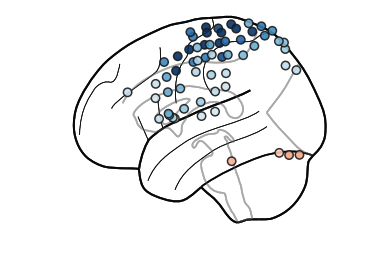

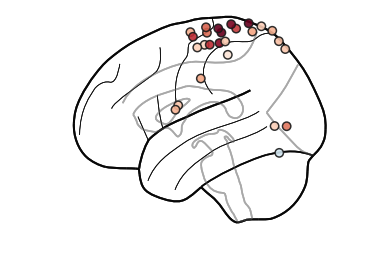

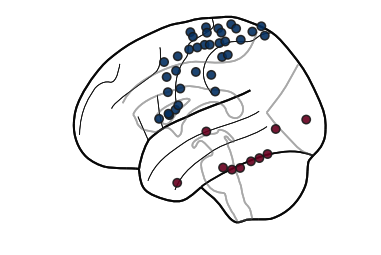

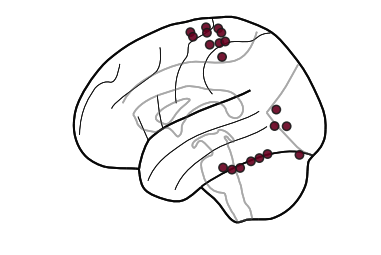

In [15]:
# colors_all = np.empty([n_conds,n_subjs,len(freq_bands)],dtype=object)
# vals_all = colors_all.copy()

# #Compute colors for plotting
# cmap = get_cmap(cmap_label)
# norm = Normalize(vmin=-vscale_val, vmax=vscale_val)
# for k in range(n_conds):
#     for s in range(n_subjs):
#         for i in range(len(freq_bands)):
#             colors,vals_tmp=[],[]
#             for j in range(len(ave_pow_patients[k,s,i])):
#                 vals_tmp.append(ave_pow_patients[k,s,i][j])
#                 if ave_pow_patients[k,s,i][j]==0:
#                     colors.append([1,1,1])
#                 else:
#                     colors.append(cmap(norm(ave_pow_patients[k,s,i][j]))[0:3])
#             colors_all[k,s,i] = colors.copy()
#             vals_all[k,s,i] = vals_tmp.copy()
            
# #Plot results
# n_rows,n_cols = 1,1
# fTitles = ['LFB ({}-{} Hz)'.format(freq_bands[0][0],freq_bands[0][1]),
#            'HFB ({}-{} Hz)'.format(freq_bands[1][0],freq_bands[1][1])]
# node_edge_colors = ['green','maroon','lime','teal','brown','black','olive','gray']

# fig_savepath = '/data1/users/stepeter/mvmt_init/figs/'
# for i in range(n_conds):
#     for j in range(len(freq_bands)):
#         f, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True)
#         for k in range(n_subjs):
#              #,figsize=(14,10))
#             chan_labels='allgood'
#             plot_ecog_electrodes_mni_in_order([elec_locs[k]],[bad_chans[k]],chan_labels,num_grid_chans=64,node_size=70,
#                                                           colors_in=colors_all[i,k,j],alpha=.9,sides_2_display='l',
#                                                           node_edge_colors='k',edge_linewidths=1.5,
#                                                           ax_in=ax,rem_zero_chans=True,zero_rem_thresh=.99,
#                                                           allLH=True,sort_vals_in = vals_all[i,k,j],sort_abs=True)
# #         ax.set_title(fTitles[j]+" "+cond_labels[ii].replace("_", " "),fontsize=18,fontweight='bold')
#         f.savefig(fig_savepath+'chan_power_'+cond_labels[i]+'_'+fband_label[j]+'.png',
#                   format='png', transparent=True,dpi=300)
# plt.show()


### Compare spectral power variability at high and low frequency bands

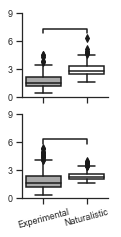

In [16]:
fig = plot_spectral_power_variability_stats(df_mad,cond_labels,my_pal_spectral_var)

# fig_savepath = '/data1/users/stepeter/mvmt_init/figs/'
# fig.savefig(fig_savepath+'power_variability_mad.png',
#             format='png', transparent=True,dpi=300)

### Compute stats and correlation between condition variances for each frequency band

In [17]:
w_results = []
for fband_curr in fband_label:
    fband_mad_df = df_mad.loc[df_mad['Fband'] == fband_curr]
    
    #Correlation
    corrs_fband = np.corrcoef(fband_mad_df.loc[fband_mad_df['Condition'] == 'Naturalistic']['MAD'].to_numpy(),
                fband_mad_df.loc[fband_mad_df['Condition'] == 'Experimental']['MAD'].to_numpy())


    print(fband_curr+': r='+str(corrs_fband[0,1]))
    
    #Stats
    w_result = pg.wilcoxon(fband_mad_df.loc[fband_mad_df['Condition'] == 'Naturalistic','MAD'], 
                fband_mad_df.loc[fband_mad_df['Condition'] == 'Experimental','MAD'], 
                tail='two-sided')
    w_results.append(w_result)
    print(fband_curr+': p='+str(w_result['p-val'].to_numpy()[0]))

LFB: r=0.16408150467620877
LFB: p=1.7966047141605805e-39
HFB: r=-0.07185886248202077
HFB: p=7.301094903458142e-14


In [18]:
w_results[0]


,W-val,tail,p-val,RBC,CLES
Wilcoxon,1009.0,two-sided,1.796605e-39,0.941,0.895


In [19]:
w_results[1]

,W-val,tail,p-val,RBC,CLES
Wilcoxon,7883.0,two-sided,7.301095e-14,0.535,0.745
